Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [4]:
NAME = "PML TuT  7"
COLLABORATORS = "Aditya Dhall AAkash Rajpal"

---

# Tutorial 7: Variational Inference

In [5]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

In [6]:
import warnings
warnings.filterwarnings('ignore')

## Exercise 1: Implementing a Gaussian Mixture Model with VI

**1.1 Generate a synthetic dataset from a GMM with $3$ clusters and $1000$ datapoint per cluster.**

First we set the parameters of the GMM we want to generate data from.

In [7]:
centers = [0., 1., 5.]
cluster_std = 1.

K = 3
SAMPLE = 1000        # number of points extracted per cluster

In [8]:
#centers_new = [1., 5.]
def generate_data(centers, std, num_samples):
    """
    Generates data from a K=len(centers) GMM where the i-th cluster is a N(centers[i], std) 
    and num_samples samples is generated from it. 
    
    Returns a numpy array of shape (len(centers) * num_samples,)
    """
    # YOUR CODE HERE
    num_clusters = len(centers)
    data = np.random.normal(loc=centers[0], scale=1, size=num_samples)
    for i, mu in enumerate(centers[1:]):
        data = np.append(data, np.random.normal(loc=mu, scale=1, size=num_samples))
    return data
    raise NotImplementedError()

X = generate_data(centers, cluster_std, SAMPLE)
#X = np.array(X_new)
assert X.shape == (K * SAMPLE,)

X[:10]

array([ 1.39323532, -0.00227649,  1.27126397,  0.13889173,  1.23590933,
        1.2491468 , -1.68006438, -0.82006388,  0.47286118,  0.99839276])

<IPython.core.display.Javascript object>


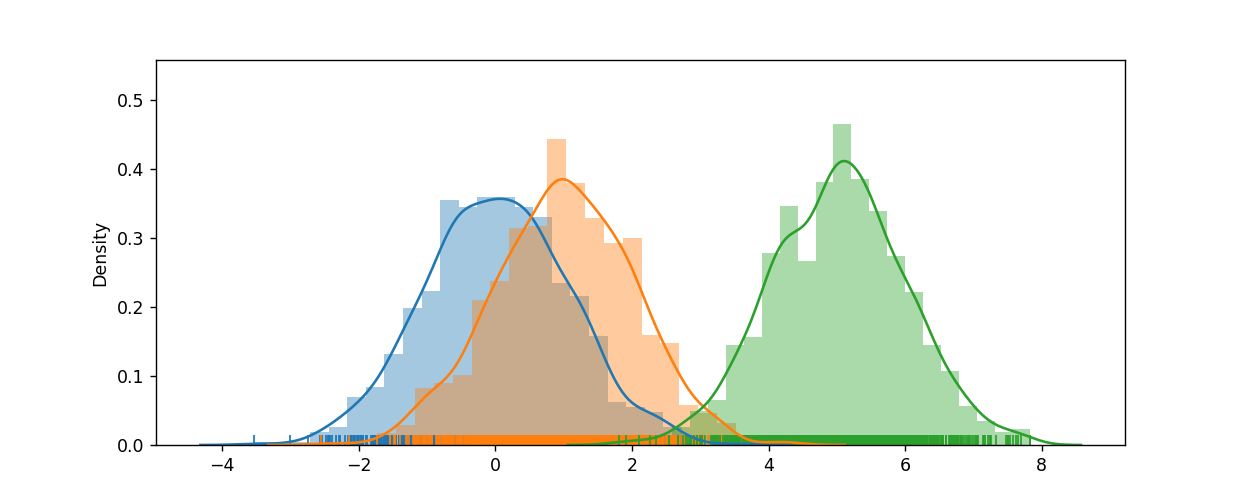

<AxesSubplot:ylabel='Density'>

In [9]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.distplot(X[:SAMPLE], ax=ax, rug=True)
sns.distplot(X[SAMPLE:SAMPLE*2], ax=ax, rug=True)
sns.distplot(X[SAMPLE*2:], ax=ax, rug=True)

The generated data should look something similar to this:
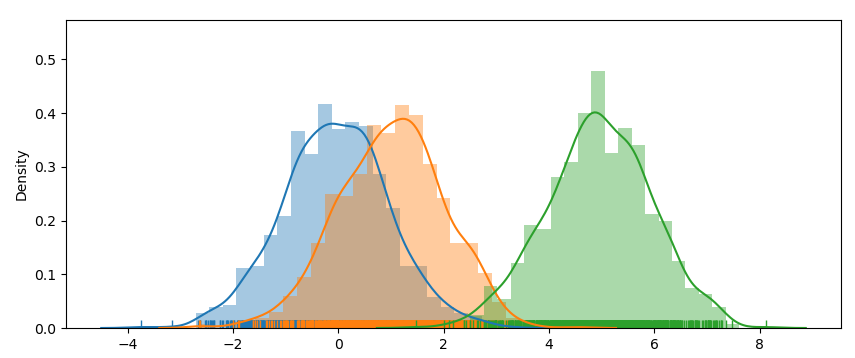

**1.2 Derive the formula of the ELBO for this model.**

$ELBO(\{\rho_{i}\}_{i=1}^{i=N}, \{m_k, s_k\}_{k=1}^K) = \dots$

$$
\begin{aligned}
\mu_{k} & \sim \mathcal{N}\left(0, 1\right) & k &=1, \ldots, K \\
c_{i} & \sim \text { Categorical }(1 / K, \ldots, 1 / K) & & i=1, \ldots, n \\
x_{i} \mid c_{i}, \mu & \sim \mathcal{N}\left(c_{i}^{T} \mu, 1\right) & i &=1, \ldots, n
\end{aligned}
$$

For  the given model , latent variables z=(u,c). K=3, n=1000.
Joint density of latent and observed variables is then given by
$$
p(\boldsymbol{\mu}, \mathbf{c}, \mathbf{x})=p(\boldsymbol{\mu}) \prod_{k=1}^{n} p\left(c_{i}\right) p\left(x_{i} \mid c_{i}, \boldsymbol{\mu}\right)
$$

Now the Mean Field Variation family states that each latent variable is independent and has its own variational factor
$$
q(\boldsymbol{\mu}, \mathbf{c})=\prod_{k=1}^{K} q\left(\mu_{k} ; m_{k}, s_{k}^{2}\right) \prod_{i=1}^{n} q\left(c_{i} ; \rho_{i}\right)
$$

 We choose $m_{k}$ and $s_{k}$ to be the variational paramters for cluster means $u_{k}$ and  $\rho_{i}$ the cluster probs for $c_{i}$ 


 

$$
\begin{aligned}
q\left(\mu_{k} ; m_{k}, s_{k}^{2}\right) &=\mathcal{N}\left(m_{k}, s_{k}^{2}\right) \\
q\left(c_{i} ; \rho_{i}\right) &=\operatorname{Categorical}\left(\rho_{i}\right),
\end{aligned}
$$

The general ELBO(q) is given by 
$$
\operatorname{ELBO}(q)=\mathbb{E}[\log p(\mathbf{z}, \mathbf{x})]-\mathbb{E}[\log q(\mathbf{z})]
$$

Expanding this for our model where z=(u,c)
$$
\operatorname{ELBO}(q)=E_{q}[\log p(\boldsymbol{x}, \boldsymbol{\mu}, \boldsymbol{c})]-E_{q}[\log q(\boldsymbol{\mu}, \boldsymbol{c})]
$$

Now using the joint density as described above and expanding the above equation term 1
$$
E_{q}[\log p(\boldsymbol{x}, \boldsymbol{\mu}, \boldsymbol{c})]=E_{q}\left[\sum_{k=1}^{K} \log p\left(\boldsymbol{\mu}_{k}\right)+\sum_{i=1}^{N}\left(\log p\left(c_{i}\right)+\log p\left(\boldsymbol{x}_{i} \mid c_{i}, \boldsymbol{\mu}\right)\right)\right]
$$


Using the MF Variation family and expanding the second term in ELBO(q) equation
$$
E_{q}[\log q(\boldsymbol{\mu}, \boldsymbol{c})]=E_{q}\left[\sum_{k=1}^{K} \log q\left(\boldsymbol{\mu}_{k}\right)+\sum_{i=1}^{N} \log q\left(c_{i}\right)\right]
$$


Re-writing the whole equation again after expanding
$$
\operatorname{ELBO}(q)=\sum_{k=1}^{K} E_{q}\left[\log p\left(\boldsymbol{\mu}_{k}\right)\right]+\sum_{i=1}^{N} E_{q}\left[\log p\left(c_{i}\right)\right]+\sum_{i=1}^{N} E_{q}\left[\log p\left(\boldsymbol{x}_{i} \mid c_{i}, \boldsymbol{\mu}\right)\right]-\sum_{k=1}^{K} E_{q}\left[\log q\left(\boldsymbol{\mu}_{k}\right)\right]-\sum_{i=1}^{N} E_{q}\left[\log q\left(c_{i}\right)\right]
$$


As you can see there are 5 Terms that need to be dealt with we start with the easiest Term 2 first
$$
\begin{aligned}
\sum_{i=1}^{N} E_{q}^{\prime}\left[\log p\left(c_{i}\right)\right] &=\sum_{i=1}^{N} E_{q_{\mu} q_{c}}\left[\log \frac{1}{K}\right] \\
&=N \log K
\end{aligned}
$$




Replacing this with N=1000 and K=3 we get a constant that can be just written as Constant So Term 2
$$
\begin{aligned}
\sum_{i=1}^{N} E_{q}^{\prime}\left[\log p\left(c_{i}\right)\right] = Constant
\end{aligned}
$$

Next Easiest is Term 5  using independent variatianal factor for each $c_{i}$
$$
\sum_{i=1}^{N} E_{q}\left[\log q\left(c_{i}\right)\right]=\sum_{i=1}^{N} \sum_{k=1}^{K} \rho_{i, k} \log \rho_{i, k}
$$

Next term is Term 4 $$
\sum_{k=1}^{K} E_{q}\left[\log q\left(\mu_{k}\right)\right]
$$
Replacing the variational factor for cluster means with Gaussian Distribution eqation we get
$$
\sum_{k=1}^{K} E_{q}\left[\log q\left(\mu_{k}\right)\right]=\sum_{k=1}^{K} E_{q}\left[\log \frac{1}{\left(2 \pi s_{k}^{2}\right)} \exp \left(\frac{-\left(\mu_{k}-m_{k}\right)^{T}\left(\mu_{k}-m_{k}\right)}{2 s_{k}^{2}}\right)\right]
$$

Expanding the above term and taking exponential outside
$$
=\sum_{k=1}^{K}\left(- \log \left(2 \pi s_{k}^{2}\right)-\frac{1}{2 s_{k}^{2}}\left(E_{q}\left[\mu_{k}^{T} \mu_{k}\right)-E_{q}\left[\mu_{k}^{T} m_{k}\right]-E_{q}\left[m_{k}^{T} \mu_{k}\right]+E_{q}\left|m_{k}^{T} m_{k}\right|\right)\right)
$$
$$
=\sum_{k=1}^{K}- \log \left(2 \pi s_{k}^{2}\right)-\sum_{k=1}^{K} \frac{1}{2 s_{k}^{2}}\left(m_{k}^{T} m_{k}+s_{k}^{2}-m_{k}^{T} m_{k}-m_{k} m_{k}^{T}+m_{k}^{T} m_{k}\right)
$$
                                                                                                          

The right hand term is a constant wrt to factor K which is equal to 3 in our case and the left hand term taking log 2 equals 
$$
\frac{1}{2} \sum_{k} \log s_{k}^{2}
$$

Till now we have the last 3 terms from our final result. Moving to solving Term 1 from the above main ELBO(q) equation expanding cluster means again using the Gaussian Distribution with 
$$
\begin{aligned}
\mu_{k} & \sim \mathcal{N}\left(0, \sigma^{2}\right)
\end{aligned}
$$ 



$$
\sum_{k=1}^{K} E_{q}\left[\log p\left(\mu_{k}\right)\right]=\sum_{k=1}^{K} E_{q_{\mu} q_{c}}\left[\log \frac{1}{\left(2 \pi \right)} \exp \left(\frac{\left(\mu_{k}\right)^{T}\left(\mu_{k}\right)}{2 }\right)\right]
$$

Expanding the exponential term and taking log outside
$$
=\sum_{k=1}^{K} E_{q_{k}}\left[\frac{\mu_{k}^{T} \mu_{k}}{2 \sigma^{2}}\right] \quad - \frac{K}{2} \log 2 \pi \sigma^{2}
$$

The right hand term is a constant when subsitituting for K=3. Taking $2 \sigma^{2}$ outside and Integrating left hand term gives 
$$
\sum_{k=1}^{K} E_{q}\left[\log p\left(\mu_{k}\right)\right]=-\frac{1}{2 \sigma^{2}} \sum_{k=1}^{K}\left[s_{k}^{2}+m_{k}^{2}]\right.
$$
This is the 2nd term in our final result

Now to obtain the final remaining term from our final result we expand the likelihood term 3 in our EBLO(q) with the following.Recall that $c_{i}$ is a one-hot vector, where only one of the element is 1. We can make use of this property and rewrite:
$$
\log p\left(x_{i} \mid c_{i}, \mu\right)=\log \prod_{j} p\left(x_{i} \mid \mu_{j}\right)^{c_{i j}}=\sum_{j} c_{i j} \log p\left(x_{i} \mid \mu_{j}\right)
$$


This give us 
$$
\sum_{i=1}^{N} E_{q}\left[\log p\left(x_{i} \mid c_{i}, \mu\right)\right]=\sum_{i=1}^{N} \sum_{k=1}^{K} E_{q_{\mu} q_{c}}\left[c_{i, k} \log p\left(x_{i} \mid \mu_{k}\right)\right]
$$

First we integrate wrt to clustter assignments and then wrt to cluster means
$$
=\sum_{i=1}^{N} \sum_{k=1}^{K} \int_{q_{\mu}} \int_{q_{c}} c_{i, k} \log p\left(x_{i} \mid \mu_{k}\right) q(\mu) q(c) d \mu dc
$$

$$
=\sum_{i=1}^{N} \sum_{k=1}^{K} \int_{q_{\mu}} \int_{q_{n}} c_{i, k} q(c) d c \log p\left(x_{i} \mid \mu_{k}\right) q(\mu) d \mu
$$
$$
=\sum_{i=1}^{N} \sum_{k=1}^{K} \int_{q_{\mu}} E_{e}\left[c_{i, k}\right] \log p\left(x_{i} \mid \mu_{k}\right) q(\mu) d \mu
$$

Using the variational parameter $\rho_{i}$
$$
=\sum_{i=1}^{N} \sum_{k=1}^{K} \rho_{i, k} E_{q_{\mu}}\left[\log p\left(x_{i} \mid \mu_{k}\right)\right]
$$

Now expanding again using the Gaussian distribution for cluster means $u_{k}$
$$
=\sum_{i=1}^{N} \sum_{k=1}^{K} \rho_{i, k} E_{q_{\mu}}\left[\log \frac{1}{\left(2 \pi \right)^{\frac{1}{2}}} \exp \left(\frac{-\left(x_{i}-\mu_{k}\right)^{T}\left(x_{i}-\mu_{k}\right)}{2 }\right)\right]
$$
$$
\left.=\sum_{i=1}^{N} \sum_{k=1}^{K} \rho_{i, k}\left(E_{q_{1}}\left[\frac{-\left(x_{i}-\mu_{k}\right)^{T}\left(x_{i}-\mu_{k}\right)}{2 }\right)\right]-\frac{1}{2} \log \left(2 \pi \right)\right)
$$

Simplyfying the above term with expansion 
$$
=\sum_{i=1}^{N} \sum_{k=1}^{K}-\frac{1}{2} \log \left(2 \pi \right) \rho_{i, k}-\frac{1}{2 \sigma^{2}} \sum_{i=1}^{N} \sum_{k=1}^{K} \rho_{i, k}\left(x_{i}^{2}-2 x_{i} m_{k}+m_{k}^{2}+s_{k}^{2}\right)
$$

Taking $\rho_{i, k}$ common and using $(a-b)^{2}$ we get the first term in our final result
$$
-\sum_{i} \sum_{k} \frac{1}{2} \rho_{i k}\left(s_{k}^{2}+\left(x_{i}-m_{k}\right)^{2}\right)
$$

Hence we derived all terms for our final result

The final result should look something similar to
$ELBO(\{\rho_{i}\}_{i=1}^{N}, \{m_k, s_k\}_{k=1}^K)  = - \sum_i \sum_k \frac{1}{2} \rho_{ik} (s_k^2 + (x_i - m_k)^2) - \sum_k \frac{1}{2 \sigma^2} (s_k^2 + m_k^2) + \frac{1}{2} \sum_k\log  s_k^2 - \sum_i \sum_k \rho_{ik}\log \rho_{ik}  + constant$

We share this so you can do the following exercises, but above you **must** write down all the derivations.

**1.3. Implement the CAVI updates for the model.**

In [10]:
class UGMM(object):
    '''Univariate GMM with CAVI'''
    def __init__(self, X, K=2, sigma=1):
        self.X = X  # Data
        self.N = X.shape[0]  # Num instances
        
        self.K = K  # Prior c (1/K) and num clusters
        self.sigma2 = sigma**2  # prior mu

    def _init(self):
        # Initializate the hyperparameters
        self.rho = np.random.dirichlet([np.random.random()*np.random.randint(1, 10)]*self.K, self.N)
        
        self.m = np.random.randint(int(self.X.min()), high=int(self.X.max()), size=self.K).astype(float)
        self.m += self.X.max()*np.random.random(self.K)
        
        self.s2 = np.ones(self.K) * np.random.random(self.K)
        
        print('Init mu')
        print(self.m)
        print('Init s2')
        print(self.s2)
        
    def get_elbo(self):
        """Compute the ELBO"""
        t1 = np.log(self.s2) - self.m/self.sigma2
        t1 = t1.sum()
        t2 = -0.5*np.add.outer(self.X**2, self.s2+self.m**2)
        t2 += np.outer(self.X, self.m)
        t2 -= np.log(self.rho)
        t2 *= self.rho
        t2 = t2.sum()
        elbo = t1 + t2
        return elbo
        raise NotImplementedError()

    def fit(self, max_iter=100, tol=1e-10):
        self._init()
        self.elbo_values = [self.get_elbo()]
        self.m_history = [self.m]
        self.s2_history = [self.s2]
        
        for iter_ in range(1, max_iter+1):
            # Sanity checks
            assert self.rho.shape == (self.N, self.K)
            assert self.m.shape == (self.K,)
            assert self.s2.shape == (self.K,)
            
            self._cavi()
            self.m_history.append(self.m)
            self.s2_history.append(self.s2)
            self.elbo_values.append(self.get_elbo())
            
            if iter_ % 5 == 0:
                print(iter_, self.m_history[iter_])
                
            if np.abs(self.elbo_values[-2] - self.elbo_values[-1]) <= tol:
                print('ELBO converged with ll %.3f at iteration %d' % (self.elbo_values[-1], iter_))
                break

        if iter_ == max_iter:
            print('ELBO ended with ll %.3f' % (self.elbo_values[-1]))

    def _cavi(self):
        self._update_rho()
        self._update_m_and_s2()

    def _update_rho(self):
        t1 = np.outer(self.X, self.m)
        t2 = -(0.5*self.m**2 + 0.5*self.s2)
        exponent = t1 + t2[np.newaxis, :]
        self.rho = np.exp(exponent)
        self.rho = self.rho / self.rho.sum(1)[:, np.newaxis]
        #raise NotImplementedError()
        
    def _update_m_and_s2(self):
        self.m = (self.rho*self.X[:, np.newaxis]).sum(0) * (1/self.sigma2 + self.rho.sum(0))**(-1)
        self.s2 = (1/self.sigma2 + self.rho.sum(0))**(-1)
        #raise NotImplementedError()
        
    def sample(self, nsamples, cluster, iteration):
        """
        Return ‘nsample’ samples from cluster ‘cluster’ given by the variational
        parameters at iteration ‘iteartion’
        """
        iter_m=self.m_history[iteration]
        #print(iter_m)
        data_sampled = np.random.normal(loc=iter_m[cluster], scale=1, size=nsamples)
        return data_sampled
        raise NotImplementedError()

**1.4. Run the algorithm and plot the results at convergence** 

In [11]:
np.random.seed(2)
ugmm = UGMM(X, 3)
ugmm.fit()

Init mu
[8.39479372 2.29923547 6.2822179 ]
Init s2
[0.81298945 0.08057334 0.68672622]
5 [5.3070681  0.37610552 4.15256136]
10 [5.37649943 0.23832729 3.14762663]
15 [ 5.13392834 -0.04909927  1.5389505 ]
20 [ 5.03036739 -0.06722639  1.11835075]
25 [ 5.02173639 -0.04867571  1.08137029]
30 [ 5.02069981 -0.04553095  1.07638355]
35 [ 5.02054732 -0.04505053  1.07563795]
40 [ 5.02052427 -0.04497754  1.07552498]
45 [ 5.02052077 -0.04496645  1.07550783]
50 [ 5.02052024 -0.04496477  1.07550522]
55 [ 5.02052016 -0.04496451  1.07550483]
60 [ 5.02052014 -0.04496447  1.07550477]
65 [ 5.02052014 -0.04496447  1.07550476]
70 [ 5.02052014 -0.04496447  1.07550476]
ELBO converged with ll -269.459 at iteration 72


<IPython.core.display.Javascript object>


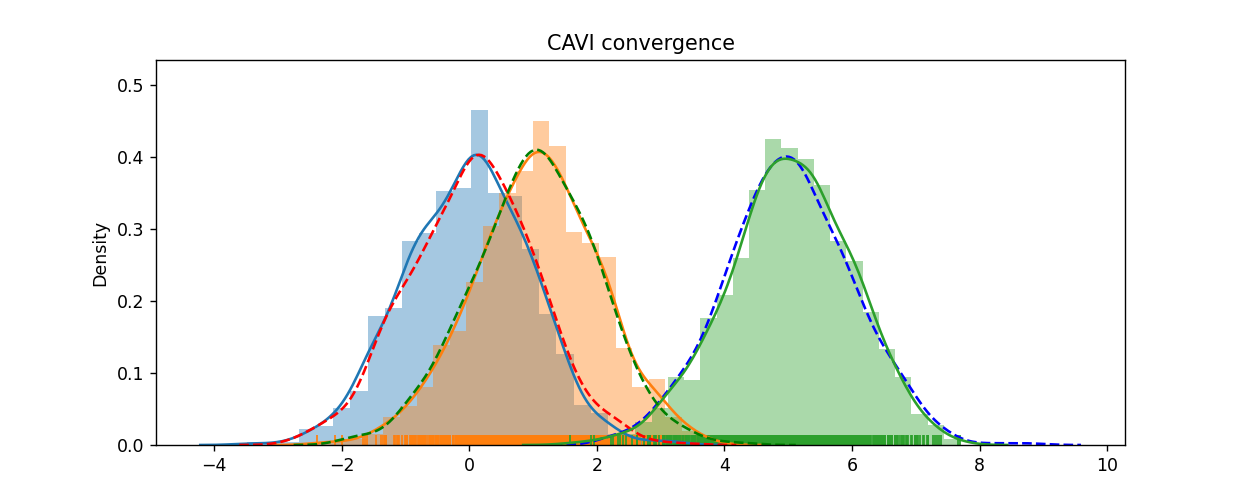

[5.02912621 0.00726856 1.04529417]
[5.02912621 0.00726856 1.04529417]
[5.02912621 0.00726856 1.04529417]


In [91]:
fig, ax = plt.subplots(figsize=(10, 4))

# First cluster
sns.distplot(X[:SAMPLE], ax=ax, hist=True, norm_hist=True)
sns.distplot(ugmm.sample(SAMPLE, cluster=0, iteration=-1), color='b', hist=False, kde=True,kde_kws={'linestyle':'--'})

# Second and third clusters
# YOUR CODE HERE
sns.distplot(X[SAMPLE:SAMPLE*2], ax=ax, rug=True)
sns.distplot(ugmm.sample(SAMPLE, cluster=1, iteration=-1), color='r', hist=False, kde=True,kde_kws={'linestyle':'--'})
sns.distplot(X[SAMPLE*2:], ax=ax, rug=True)
sns.distplot(ugmm.sample(SAMPLE, cluster=2, iteration=-1), color='g', hist=False, kde=True,kde_kws={'linestyle':'--'})
#raise NotImplementedError()

ax.set(title='CAVI convergence');

**1.5. Plot the behavior of the ELBO over iteration time. Comment.**

Use the plot to detect changing points in the ELBO and mark them on the plot.

<IPython.core.display.Javascript object>


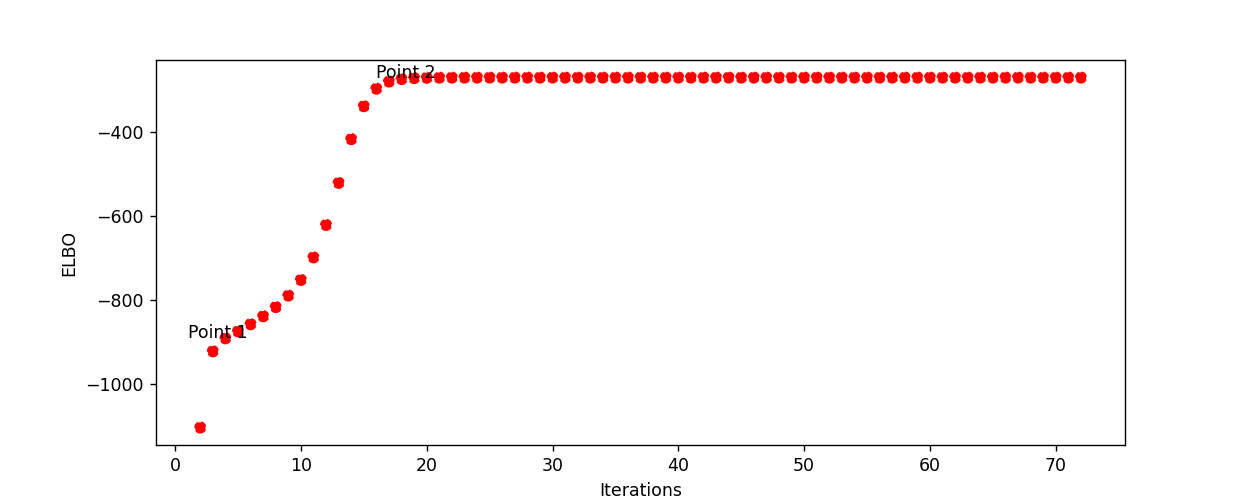

In [12]:
# Hint: You can use the elbo_values attribute save during fitting and the scatter function from matplotlib
fig, ax = plt.subplots(figsize=(10, 4))
iterations_range=list(range(2, len(ugmm.elbo_values))) 
ax.set_xlabel('Iterations')
ax.set_ylabel('ELBO')
ax.annotate("Point 1", (1, ugmm.elbo_values[4]))
ax.annotate("Point 2", (16, ugmm.elbo_values[20]))
ax.scatter(iterations_range,ugmm.elbo_values[2:],c='r',linestyle='dashed', marker='o')
# YOUR CODE HERE
#raise NotImplementedError()

**1.6. Plot result at the beginning and at the changing points.**

Beginning

<IPython.core.display.Javascript object>


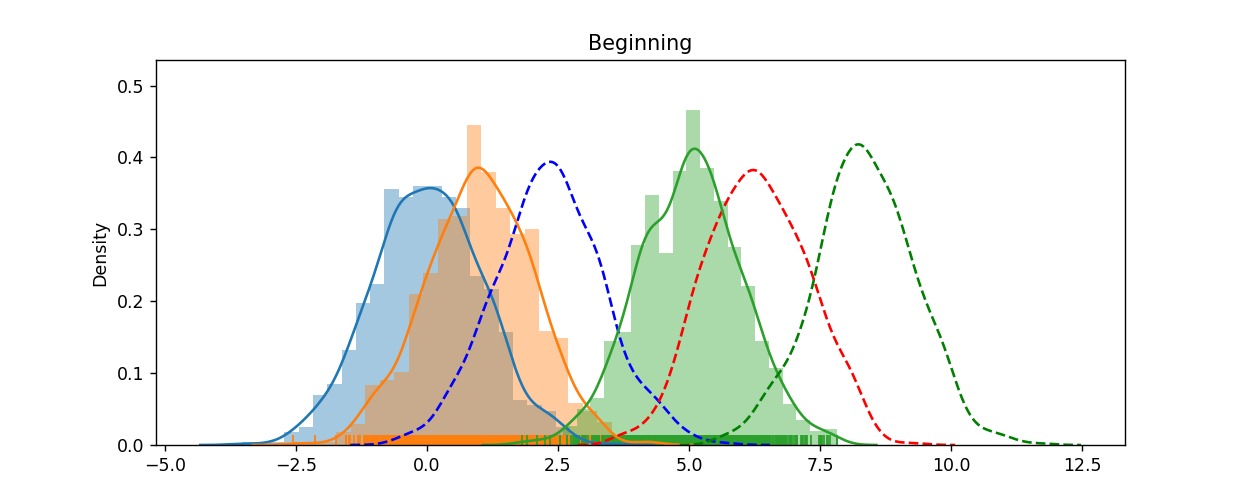

In [13]:
fig, ax = plt.subplots(figsize=(10, 4))

sns.distplot(X[:SAMPLE], ax=ax, hist=True, norm_hist=True)
sns.distplot(ugmm.sample(SAMPLE, cluster=1, iteration=0), color='b', hist=False, kde=True,kde_kws={'linestyle':'--'})
#raise NotImplementedError()
sns.distplot(X[SAMPLE:SAMPLE*2], ax=ax, rug=True)
sns.distplot(ugmm.sample(SAMPLE, cluster=2, iteration=0), color='r', hist=False, kde=True,kde_kws={'linestyle':'--'})
sns.distplot(X[SAMPLE*2:], ax=ax, rug=True)
sns.distplot(ugmm.sample(SAMPLE, cluster=0, iteration=0), color='g', hist=False, kde=True,kde_kws={'linestyle':'--'})
#raise NotImplementedError()


ax.set(title='Beginning');

Changing points (two plots)

<IPython.core.display.Javascript object>


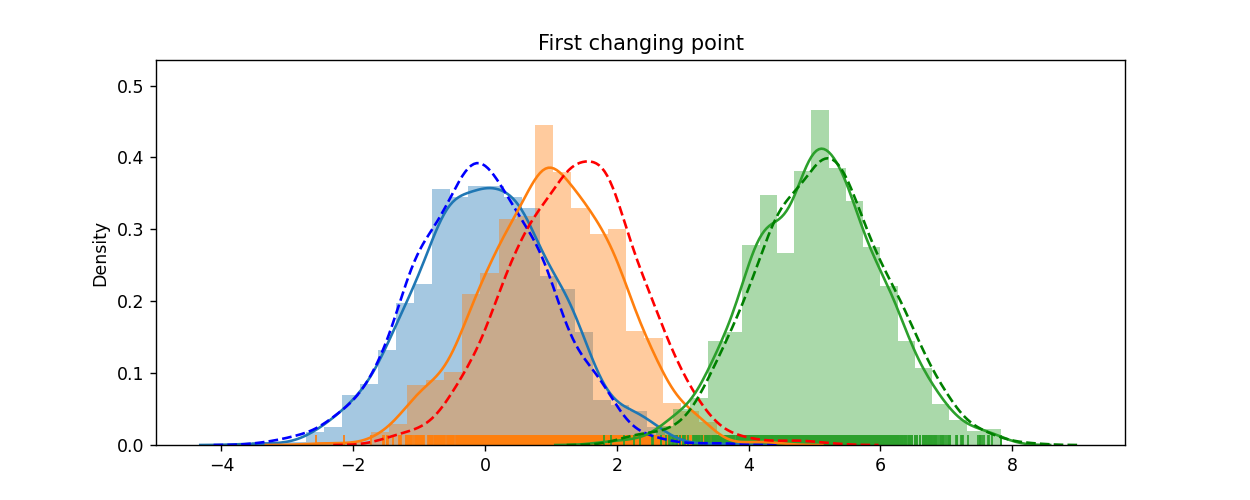

In [14]:
fig, ax = plt.subplots(figsize=(10, 4))



sns.distplot(X[:SAMPLE], ax=ax, hist=True, norm_hist=True)
sns.distplot(ugmm.sample(SAMPLE, cluster=1, iteration=16), color='b', hist=False, kde=True,kde_kws={'linestyle':'--'})
#raise NotImplementedError()
sns.distplot(X[SAMPLE:SAMPLE*2], ax=ax, rug=True)
sns.distplot(ugmm.sample(SAMPLE, cluster=2, iteration=16), color='r', hist=False, kde=True,kde_kws={'linestyle':'--'})
sns.distplot(X[SAMPLE*2:], ax=ax, rug=True)
sns.distplot(ugmm.sample(SAMPLE, cluster=0, iteration=16), color='g', hist=False, kde=True,kde_kws={'linestyle':'--'})
#raise NotImplementedError()
ax.set(title='First changing point');

<IPython.core.display.Javascript object>


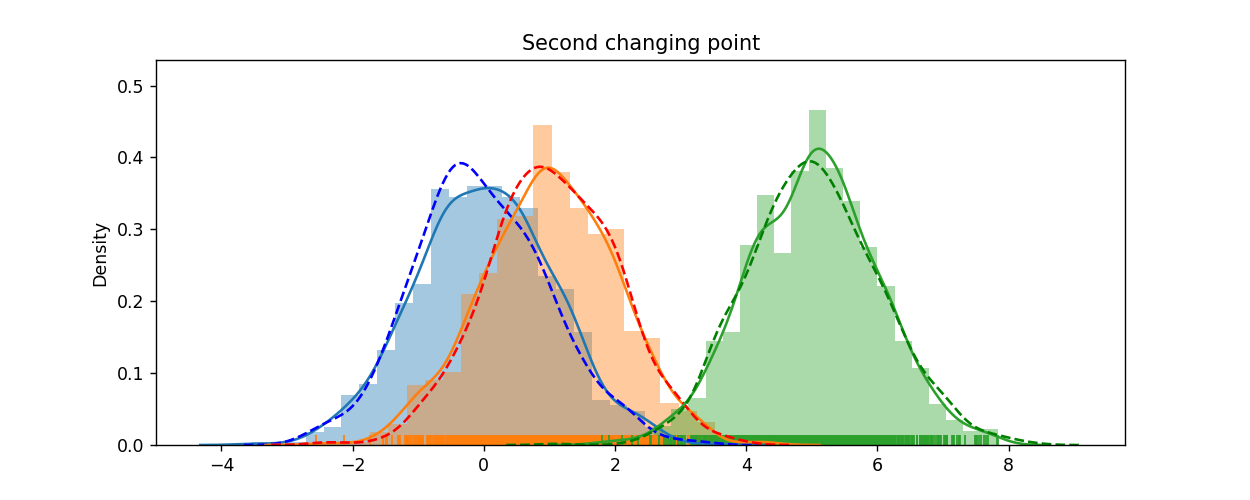

In [15]:
fig, ax = plt.subplots(figsize=(10, 4))



sns.distplot(X[:SAMPLE], ax=ax, hist=True, norm_hist=True)
sns.distplot(ugmm.sample(SAMPLE, cluster=1, iteration=60), color='b', hist=False, kde=True,kde_kws={'linestyle':'--'})
#raise NotImplementedError()
sns.distplot(X[SAMPLE:SAMPLE*2], ax=ax, rug=True)
sns.distplot(ugmm.sample(SAMPLE, cluster=2, iteration=60), color='r', hist=False, kde=True,kde_kws={'linestyle':'--'})
sns.distplot(X[SAMPLE*2:], ax=ax, rug=True)
sns.distplot(ugmm.sample(SAMPLE, cluster=0, iteration=60), color='g', hist=False, kde=True,kde_kws={'linestyle':'--'})
#raise NotImplementedError()
ax.set(title='Second changing point');